In [1]:
import torch
import matplotlib.pyplot as plt
import sys
from neuralop.models import FNO
from neuralop import Trainer
from neuralop.datasets import load_darcy_flow_small
from neuralop.utils import count_model_params
from neuralop import LpLoss, H1Loss
from utils import get_dataloaders, TensorDataset
import numpy as np
from timeit import default_timer
import torch.nn.functional as F
import torch.nn as nn
from losses import EnergyScore, KernelScore, VariogramScore
from models import FNO_reparam, FNO_complex

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [2]:
# Subsampling rate
sampling_rate = 2
ntrain = 1500
ntest = 150
batch_size = 64

t1 = 5
t2 = 10
data = np.load("data/ks_1d_data.npy").astype(np.float32)

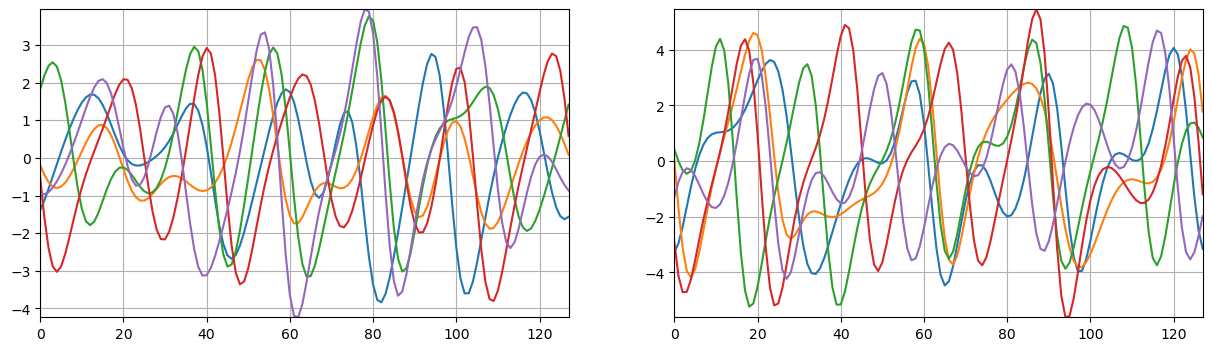

In [3]:
# Example plot
n_samples = np.random.randint(0,ntrain,5)

fig, axs = plt.subplots(1, 2, figsize = (15,4))
index = 0
for i in n_samples:
    axs[0].plot(data[i, t1])
    axs[1].plot(data[i, t2])


axs[0].grid(True)
axs[0].margins(0)
axs[1].grid(True)
axs[1].margins(0)

In [4]:
grid_range = 1

x_data = torch.tensor(data[:,t1])
y_data = torch.tensor(data[:,t2])
x_data = (x_data - x_data.mean()) / x_data.std()
y_data = (y_data - y_data.mean()) / y_data.std()
size_x = x_data.shape[1]
size_x_train = int(size_x/sampling_rate)

# Add channel dimension
x_data = x_data[:, None, :]
y_data = y_data[:, None, :]

x_train, y_train = x_data[:ntrain,:,::sampling_rate], y_data[:ntrain,:,::sampling_rate]
x_test, y_test = x_data[-ntest:], y_data[-ntest:]

# Add grid
gridx_train = torch.tensor(np.linspace(0, grid_range, size_x_train), dtype=torch.float)
gridx_train = gridx_train.reshape(1, 1, size_x_train)
gridx_test = torch.tensor(np.linspace(0, grid_range, size_x), dtype=torch.float)
gridx_test = gridx_test.reshape(1, 1, size_x)


x_train = torch.cat((x_train, gridx_train.repeat([ntrain, 1, 1])), dim=1)
x_test = torch.cat((x_test, gridx_test.repeat([ntest, 1, 1])), dim=1)

train_loader = torch.utils.data.DataLoader(TensorDataset(x_train, y_train),
                                        batch_size=batch_size, shuffle=True)
test_loader = torch.utils.data.DataLoader(TensorDataset(x_test, y_test),
                                        batch_size=batch_size, shuffle=False)
test_data = [x_test, y_test]

# Losses and parameters

In [7]:
l2loss = LpLoss(d=1, p=2, L = 50.0)
energy_score = EnergyScore(d = 1, p = 2, type = "lp", L = 50.0)
#energy_score = KernelScore(d=1, p=2, type = "lp",  L = 50.0, kernel ="gauss", gamma = 10)
variogram_score = VariogramScore(p=1)

# Training parameters
epochs = 25
learning_rate = 0.001
dropout_rate = 0.1

# MC dropout

In [6]:
def generate_mc_samples(model, x, shape, n_samples=100):
    samples = torch.zeros(*shape, n_samples)
    for i in range(n_samples):
        with torch.no_grad():
            samples[...,i] = model(x).detach()
    return samples

In [7]:
model = FNO(n_modes=(16,), hidden_channels=32, projection_channels=64,
             in_channels = 2, use_mlp=True, mlp_dropout=dropout_rate)
model = model.to(device)

n_params = count_model_params(model)
print(f'\nOur model has {n_params} parameters.')
sys.stdout.flush()



Our model has 93537 parameters.


In [8]:
optimizer = torch.optim.Adam(model.parameters(),
                                lr=learning_rate)
scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=30)

In [9]:
train_loss = torch.zeros(epochs)
test_loss = torch.zeros(epochs)

for ep in range(epochs):
    model.train()
    t1 = default_timer()
    train_mse = 0
    train_l2 = 0
    for sample in train_loader:
        x = sample["x"].to(device)
        y = sample["y"].to(device)

        optimizer.zero_grad()
        out = model(x)
        
        mse = F.mse_loss(out.view(batch_size, -1), y.view(batch_size, -1))
        l2 = l2loss(out.view(batch_size, -1), y.view(batch_size, -1))
        l2.backward() # l2 relative loss

        optimizer.step()
        train_mse += mse.item()
        train_l2 += l2.item()

    scheduler.step()
    model.eval()
    test_l2 = 0.0
    with torch.no_grad():
        for sample in test_loader:
            x = sample["x"].to(device)
            y= sample["y"].to(device)

            out = model(x)
            test_l2 += l2loss(out.view(batch_size, -1), y.view(batch_size, -1)).item()

    train_mse /= len(train_loader)
    train_l2 /= ntrain
    test_l2 /= ntest
    
    train_loss[ep] = train_l2
    test_loss[ep] = test_l2

    t2 = default_timer()
    print('Epoch-{}, Time-{:0.4f}, Train-MSE-{:0.4f}, Train-L2-{:0.4f}, Test-L2-{:0.4f}'
          .format(ep, t2-t1, train_mse, train_l2, test_l2))

Epoch-0, Time-2.0288, Train-MSE-0.9029, Train-L2-0.9706, Test-L2-1.1387
Epoch-1, Time-0.6050, Train-MSE-0.7342, Train-L2-0.8712, Test-L2-1.0267
Epoch-2, Time-0.6143, Train-MSE-0.5459, Train-L2-0.7469, Test-L2-0.8260
Epoch-3, Time-0.6034, Train-MSE-0.3535, Train-L2-0.5977, Test-L2-0.6214
Epoch-4, Time-0.6247, Train-MSE-0.2186, Train-L2-0.4694, Test-L2-0.5169
Epoch-5, Time-0.6034, Train-MSE-0.1558, Train-L2-0.3941, Test-L2-0.4119
Epoch-6, Time-0.6285, Train-MSE-0.1184, Train-L2-0.3435, Test-L2-0.3444
Epoch-7, Time-0.6205, Train-MSE-0.1009, Train-L2-0.3176, Test-L2-0.3223
Epoch-8, Time-0.5764, Train-MSE-0.0855, Train-L2-0.2917, Test-L2-0.2930
Epoch-9, Time-0.6201, Train-MSE-0.0726, Train-L2-0.2687, Test-L2-0.2797
Epoch-10, Time-0.6087, Train-MSE-0.0699, Train-L2-0.2637, Test-L2-0.2697
Epoch-11, Time-0.6192, Train-MSE-0.0625, Train-L2-0.2494, Test-L2-0.2411
Epoch-12, Time-0.6104, Train-MSE-0.0596, Train-L2-0.2433, Test-L2-0.2383
Epoch-13, Time-0.6066, Train-MSE-0.0542, Train-L2-0.2321, Tes

In [10]:
# %%
model.train()
""" Prediction """
pred = []
with torch.no_grad():    
    index = 0
    for sample in test_loader:
        x = sample["x"].to(device)
        y = sample["y"].to(device)
        out = generate_mc_samples(model, x, y.shape, n_samples=500)
        pred.append( out )


pred = torch.cat((pred))
mse_dropout = F.mse_loss(pred.mean(axis = -1).view(-1, size_x), y_test.view(-1, size_x)).item()
es_dropout = energy_score(pred, y_test).item()

print('MSE:', mse_dropout)
print('ES:', es_dropout)

MSE: 0.0246773362159729
ES: 0.7449131011962891


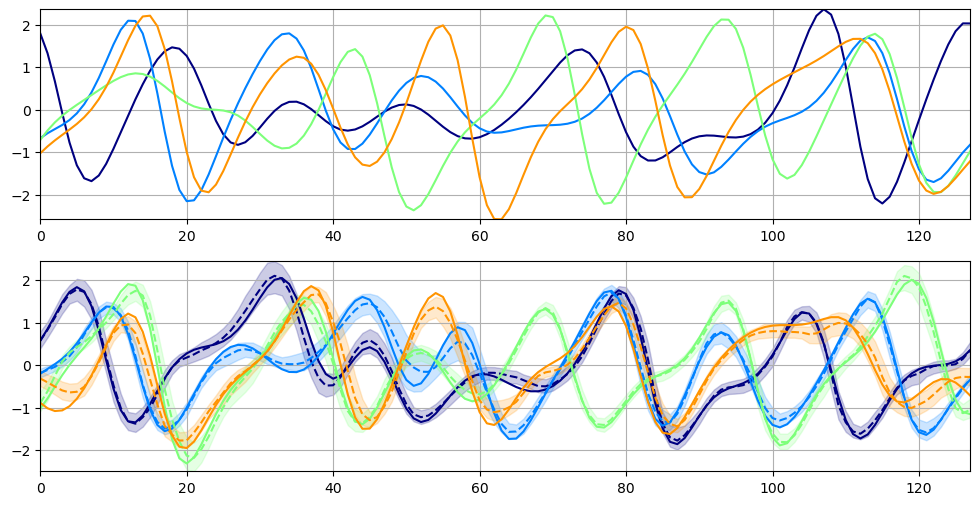

In [11]:
x_test, y_test = test_data
# %%


colormap = plt.cm.jet
colors = [colormap(i) for i in np.linspace(0, 1, 5)]

""" Plotting """ 
fig, axs = plt.subplots(2, 1, figsize = (12, 6))
index = 0
for i in range(y_test.shape[0]):
    if i % 40 == 1:
        axs[1].plot(y_test[i, 0].cpu().numpy(), color=colors[index], label='Actual')
        axs[1].plot(pred[i,0].mean(axis = -1).cpu().numpy(), '--', color=colors[index], label='Prediction')
        axs[0].plot(x_test[i,0].cpu().numpy(), color=colors[index], label='Actual')
        # Plot confidence bands
        axs[1].fill_between(np.arange(0, size_x), pred[i,0].quantile(0.025, axis = -1).cpu().numpy(),
                            pred[i,0].quantile(0.975, axis = -1).cpu().numpy() , color=colors[index], alpha=0.2)
        index += 1

axs[0].grid(True)
axs[0].margins(0)
axs[1].grid(True)
axs[1].margins(0)

# PFNO

In [12]:
sample_model = FNO_reparam(n_modes=(16,), hidden_channels=32, projection_channels=64, in_channels=2, n_samples = 5,
                           use_mlp=True, mlp_dropout=0)
sample_model.to(device)
# Model and optimizer
optimizer = torch.optim.Adam(sample_model.parameters(), lr = learning_rate)
scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=30)

In [13]:
train_loss = torch.zeros(epochs)
test_loss = torch.zeros(epochs)

for ep in range(epochs):
    sample_model.train()
    t1 = default_timer()
    train_l2 = 0
    for sample in train_loader:
        x = sample["x"].to(device)
        y = sample["y"].to(device)

        optimizer.zero_grad()
        out = sample_model(x)
        
        l2 = energy_score(out,y) 
        l2.backward() # l2 relative loss

        optimizer.step()
        train_l2 += l2.item()

    scheduler.step()
    test_l2 = 0.0
    with torch.no_grad():
        for sample in test_loader:
            x = sample["x"].to(device)
            y= sample["y"].to(device)

            out = sample_model(x)
            test_l2 += energy_score(out,y).item()

    train_l2 /= ntrain
    test_l2 /= ntest
    
    train_loss[ep] = train_l2
    test_loss[ep] = test_l2

    t2 = default_timer()
    print('Epoch-{}, Time-{:0.4f}, Train-L2-{:0.4f}, Test-L2-{:0.4f}'
          .format(ep, t2-t1, train_l2, test_l2))

Epoch-0, Time-0.6758, Train-L2-0.0899, Test-L2-0.0913
Epoch-1, Time-0.6843, Train-L2-0.0814, Test-L2-0.0831
Epoch-2, Time-0.6707, Train-L2-0.0690, Test-L2-0.0653
Epoch-3, Time-0.6663, Train-L2-0.0520, Test-L2-0.0503
Epoch-4, Time-0.6770, Train-L2-0.0398, Test-L2-0.0409
Epoch-5, Time-0.6832, Train-L2-0.0318, Test-L2-0.0319
Epoch-6, Time-0.6965, Train-L2-0.0251, Test-L2-0.0278
Epoch-7, Time-0.6840, Train-L2-0.0217, Test-L2-0.0248
Epoch-8, Time-0.6816, Train-L2-0.0196, Test-L2-0.0236
Epoch-9, Time-0.6696, Train-L2-0.0178, Test-L2-0.0218
Epoch-10, Time-0.6786, Train-L2-0.0166, Test-L2-0.0207
Epoch-11, Time-0.6621, Train-L2-0.0156, Test-L2-0.0192
Epoch-12, Time-0.6646, Train-L2-0.0143, Test-L2-0.0179
Epoch-13, Time-0.6665, Train-L2-0.0136, Test-L2-0.0174
Epoch-14, Time-0.6788, Train-L2-0.0130, Test-L2-0.0165
Epoch-15, Time-0.6790, Train-L2-0.0127, Test-L2-0.0166
Epoch-16, Time-0.6734, Train-L2-0.0120, Test-L2-0.0160
Epoch-17, Time-0.6665, Train-L2-0.0116, Test-L2-0.0159
Epoch-18, Time-0.689

In [14]:
# %%
sample_model.eval()
""" Prediction """
pred = []
with torch.no_grad():    
    index = 0
    for sample in test_loader:
        x = sample["x"].to(device)
        y = sample["y"].to(device)
        out = sample_model(x, n_samples = 500).detach().cpu()
        pred.append( out )


pred = torch.cat((pred))
mse = F.mse_loss(pred.mean(axis = -1).view(-1, size_x), y_test.view(-1, size_x)).item()
es = energy_score(pred, y_test).item()

print('MSE:', mse)
print('ES:', es)

MSE: 0.020745623856782913
ES: 0.6930670738220215


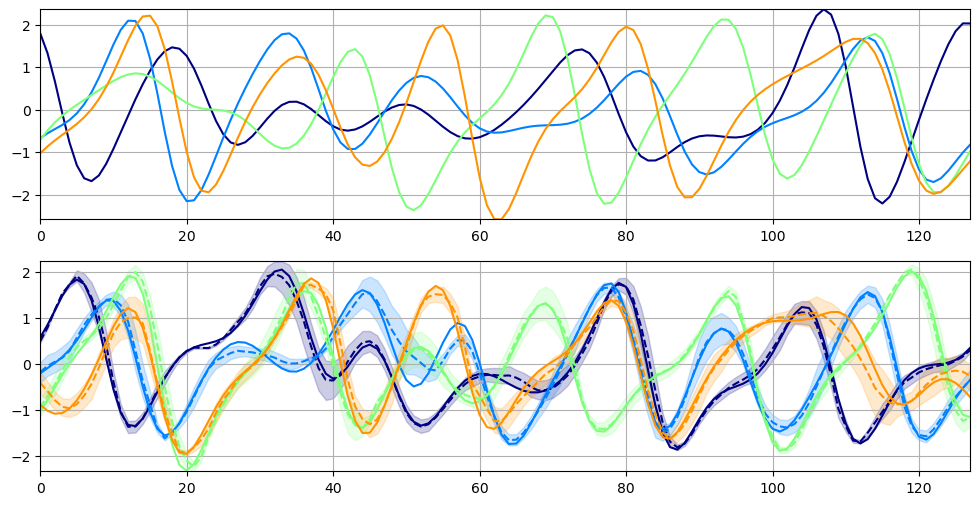

In [15]:
x_test, y_test = test_data
# %%


colormap = plt.cm.jet
colors = [colormap(i) for i in np.linspace(0, 1, 5)]

""" Plotting """ 
fig, axs = plt.subplots(2, 1, figsize = (12, 6))
index = 0
for i in range(y_test.shape[0]):
    if i % 40 == 1:
        axs[1].plot(y_test[i, 0].cpu().numpy(), color=colors[index], label='Actual')
        axs[1].plot(pred[i,0].mean(axis = -1).cpu().numpy(), '--', color=colors[index], label='Prediction')
        axs[0].plot(x_test[i,0].cpu().numpy(), color=colors[index], label='Actual')
        # Plot confidence bands
        axs[1].fill_between(np.arange(0, size_x), pred[i,0].quantile(0.025, axis = -1).cpu().numpy(),
                            pred[i,0].quantile(0.975, axis = -1).cpu().numpy() , color=colors[index], alpha=0.2)
        index += 1

axs[0].grid(True)
axs[0].margins(0)
axs[1].grid(True)
axs[1].margins(0)

In [16]:
# Comparison
print('MSE-Dropout:', mse_dropout)
print('ES-Dropout:', es_dropout)

print('MSE:', mse)
print('ES:', es)

MSE-Dropout: 0.0246773362159729
ES-Dropout: 0.7449131011962891
MSE: 0.020745623856782913
ES: 0.6930670738220215


# Test complex neural network

In [8]:
def complex_norm(xr, xi, yr, yi, **kwargs):
    """Calculates the complex norm between two tensors

    Args:
        x (Tensor): First tensor of shape (B, n_samples_x, flatted_dims).
        y (Tensor): Second tensor of shape (B, n_samples_y, flatted_dims).

    Returns:
        Tensor: Complex norm norm
    """
    # Calculate dot product
    diff_real = torch.unsqueeze(xr) - torch.unsqueeze(yr)
    diff_complex = torch.unsqueeze(xi) - torch.unsqueeze(yi)
    norm = torch.sqrt(torch.sum(diff_real * diff_complex, dim = -1))
    
    return torch.real(norm)

In [9]:
sample_model = FNO_complex(n_modes=(16,), hidden_channels=32, projection_channels=64, in_channels=2, n_samples = 5,
                           use_mlp=True, mlp_dropout=0, output_type = "complex")
sample_model.to(device)
# Model and optimizer
optimizer = torch.optim.Adam(sample_model.parameters(), lr = learning_rate)
scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=30)
energy_score_complex = complex_norm#EnergyScore(d = 1, p = 2, type = "complex", L = 50.0)

train_mode = [64]
test_mode = [128]
fft_dims = [-1]
fft_norm = "forward"

In [13]:
train_loss = torch.zeros(epochs)
test_loss = torch.zeros(epochs)

for ep in range(epochs):
    sample_model.train()
    t1 = default_timer()
    train_l2 = 0
    for sample in train_loader:
        x = sample["x"].to(device)
        y = sample["y"].to(device)
        # Transform y
        y = torch.fft.rfftn(y, s=train_mode, dim=fft_dims, norm=fft_norm)

        optimizer.zero_grad()
        out= sample_model(x)
        
        l2 = energy_score_complex(out[0], out[1], torch.real(y), torch.imag(y)) 
        l2.backward() # l2 relative loss

        optimizer.step()
        train_l2 += l2.item()

    scheduler.step()
    test_l2 = 0.0
    with torch.no_grad():
        for sample in test_loader:
            x = sample["x"].to(device)
            y = sample["y"].to(device)
            # Transform y
            y = torch.fft.rfftn(y, s=test_mode, dim=fft_dims, norm=fft_norm)

            out = sample_model(x)
            test_l2 += energy_score_complex(out,y).item()


    train_l2 /= ntrain
    test_l2 /= ntest
    
    train_loss[ep] = train_l2
    test_loss[ep] = test_l2

    t2 = default_timer()
    print('Epoch-{}, Time-{:0.4f}, Train-L2-{:0.4f}, Test-L2-{:0.4f}'
          .format(ep, t2-t1, train_l2, test_l2))

TypeError: unsqueeze() missing 1 required positional arguments: "dim"

In [ ]:
# %%
sample_model.eval()
""" Prediction """
pred = []
with torch.no_grad():    
    index = 0
    for sample in test_loader:
        x = sample["x"].to(device)
        y = sample["y"].to(device)
        out = sample_model(x, n_samples = 500).detach().cpu()
        pred.append( out )


pred = torch.cat((pred))
mse_complex = F.mse_loss(pred.mean(axis = -1).view(-1, size_x), y_test.view(-1, size_x)).item()
es_complex = energy_score(pred, y_test).item()

print('MSE:', mse_complex)
print('ES:', es_complex)

MSE: 0.9507707953453064
ES: 4.9772725105285645


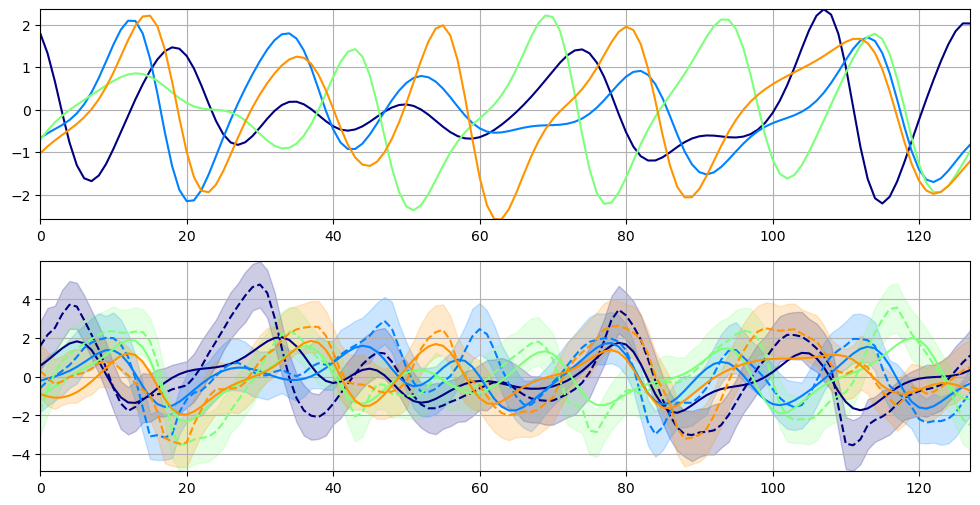

In [ ]:
x_test, y_test = test_data
# %%


colormap = plt.cm.jet
colors = [colormap(i) for i in np.linspace(0, 1, 5)]

""" Plotting """ 
fig, axs = plt.subplots(2, 1, figsize = (12, 6))
index = 0
for i in range(y_test.shape[0]):
    if i % 40 == 1:
        axs[1].plot(y_test[i, 0].cpu().numpy(), color=colors[index], label='Actual')
        axs[1].plot(pred[i,0].mean(axis = -1).cpu().numpy(), '--', color=colors[index], label='Prediction')
        axs[0].plot(x_test[i,0].cpu().numpy(), color=colors[index], label='Actual')
        # Plot confidence bands
        axs[1].fill_between(np.arange(0, size_x), pred[i,0].quantile(0.025, axis = -1).cpu().numpy(),
                            pred[i,0].quantile(0.975, axis = -1).cpu().numpy() , color=colors[index], alpha=0.2)
        index += 1

axs[0].grid(True)
axs[0].margins(0)
axs[1].grid(True)
axs[1].margins(0)

In [ ]:
# Comparison
print('MSE-Dropout:', mse_dropout)
print('ES-Dropout:', es_dropout)

print('MSE:', mse)
print('ES:', es)

print('MSE Complex:', mse_complex)
print('ES Complex:', es_complex)

MSE-Dropout: 0.7303006052970886
ES-Dropout: 5.3254899978637695
MSE: 0.7571939826011658
ES: 4.305214881896973
MSE Complex: 0.9507707953453064
ES Complex: 4.9772725105285645
